# <center>Part 1</center>


# Import
**How to install pylsd binding**

 

```bash
git clone https://github.com/primetang/pylsd.git
cd pylsd
nano ./pylsd/lsd.py
```

- If anaconda environment variables are not used, the default 'python' command is enough
- With nano, we need to change line 15 and 20 provoking an error with tmp file name

```python
# temp = os.path.abspath(str(np.random.randint(1, 1000000)) + 'ntl.txt').replace('\\', '/')
temp = os.path.abspath(str(np.random.randint(1, 1000000)) + 'ntl.txt').replace('\\', '/').encode('utf-8')

# lsdlib.lsdGet(src, ctypes.c_int(rows), ctypes.c_int(cols), temp)
lsdlib.lsdGet(src, ctypes.c_int(rows), ctypes.c_int(cols), ctypes.c_char_p(temp))
```

- Then, we will launch the python script for installation. We need to use the python command corresponding to the correct anaconda environment variable or the python 3.6 command (Careful to the path set up for 'python' cmd)

```bash
path/to/Annaconda/environement/python setup.py install
```

In [1]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import edge_detector as ed             # A edge detector
import segment_detector as sd          # A segment detector
import edge_classifier as ec           # A edge classifier
import imgTools                        # A image tools
import import_images as im

##   1.1. Loading and displaying OpenCV images

In [2]:
# Load images
building = cv2.imread('image_database/Building.png')
building_gray = cv2.imread('image_database/Building.png', cv2.IMREAD_GRAYSCALE)
road_gray = cv2.imread('image_database/Road.png', cv2.IMREAD_GRAYSCALE)
road = cv2.imread('image_database/Road.png')

In [3]:
def display(title, img, width=15, height=15):
    return imgTools.display(title, img, width, height)

def multiDisplay(titles, imgs, imgPerLine, width=15, height=15):
    return imgTools.multiDisplay(titles, imgs, imgPerLine, width, height)

## 1.2. Edge points extraction

### 1.2.1 Morphological Gradient of Beucher


The morphological gradient of Beucher is GE(f) + GD(f) where GE and GD are respectively the erosion gradient and the dilation gradient. DIfferent size of kernel were tested but nothing seems to be working well. The method is dropped without further research.

In [ ]:
# Choose the kernel for the Gradient of Beucher
from ipywidgets import interact, fixed

def update(kSize=2):
    imgs = []
    names = []
    for img in [building_gray, road_gray] : 
        img_edges = ed.gradientOfBeucher(img, kSize, kSize)
        imgs.append(img_edges)
        names.append('Edge extraction using Morphological Gradient of Beucher')
    multiDisplay(names, imgs, 2, width=15, height=10)

interact(update, kSize = (0, 20, 1))

GRADIENT_K_SIZE = 2

### 1.2.2 Non linear Laplacian

The non-linear laplacian is equal to GD(f) - GE(f) where GE and GD are respectively the erosion gradient and the dilation gradient. The non-linear laplacian filter has been implemented to experiment with non-linear filters. Its results were not bad but those of Canny's algorithm were preferred. That is why it has not been kept for the next steps.

In [ ]:
# Choose the kernel for the Gradient of Beucher
from ipywidgets import interact, fixed


def update(kSize=2):
    imgs = []
    names = []
    for img in [building_gray, road_gray] : 
        img_edges = ed.nonLinearLaplacian(img, kernel_type=cv2.MORPH_RECT, k1=kSize, k2=kSize)
        imgs.append(img_edges)
        names.append('Edge extraction using non linear Laplacian')
    multiDisplay(names, imgs, 2, width=15, height=10)

interact(update, kSize = (0, 20, 1))

gradient_k_size = 2

### 1.2.3 Canny algorithm

Canny is a popular edge detection algorithm developed by John F. Canny.
It is composed of 4 steps.

- Apply noise reduction filter ( Gaussian 5x5)
- Use Sobel kernel to obtain the first derivative gradients in the two 
main axis ( $G_{x}$ and $G_{y}$ ) and compute for each pixel the edge gradient and direction

 $ EdgeGradient(x,y) = \sqrt{G_{x} + G_{y}}$
 
 $ Direction(x) = tan^{-1}(\frac{G_{y}}{G_{x}})$ (rounded to 4 directions)
 
- For each pixel, check if it is a local maximum in the direction of the gradient. If not, discard it.
We obtain the 'thin edges'

- All the thin edges with an edge gradient above the maximum threshold value are the 'sure edges', and so kept.
All the thin edges below the minmum threshold are discarded.
The thin edges between the values are kept only if there are connected to 'sure edges'
The result, the 'strong edges' is what the algorithm sent.

The algorithm is used a lot because it has been created to be optimal 
following three criteria : good detection (low error rate), good localisation (min the distance between found and real edges),
clarity (one response by edge, no false positive).
The main drawback is that there are no generic methodes to obtain the optimal parameters for all types of image
 
We try four versions, with different kind of preprocessing and by using Canny() OpenCV function
The parameters tuned are the threshold values (only in vanilla version, because there are computed automatically using the 
image median), the sobel kernel size and the kernel size of the gaussian/median blur.

The results are globally good, better than the previous methods if well tuned. We see that for some types of images 
with a lot of vegetation, the version
with a gaussian blur applied to a downsized image gives better results. But in images
where there are clear vanishing lines in the border of the image, the median blur version
gives better results. For small to moderate levels of Gaussian noise, the median filter is demonstrably better than 
Gaussian blur at removing noise whilst preserving edges for a given, fixed window size. 



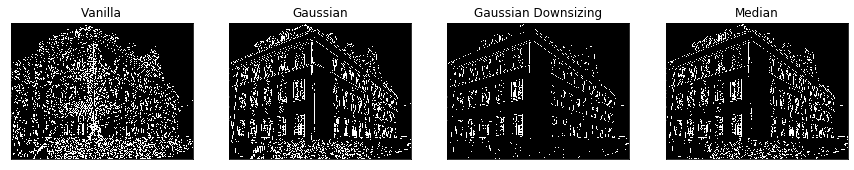

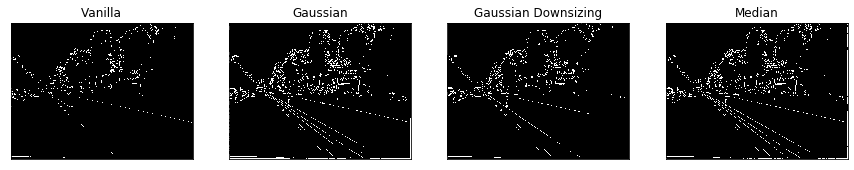

In [5]:
for img in [building_gray, road_gray] : 
    img_edges_vanilla = ed.canny_vanilla(img)
    img_edges_gaussian = ed.canny_gaussian_blur(img)
    img_edges_gaussian_down = ed.canny_gaussian_blur_downsize(img)
    img_edges_median_blur = ed.canny_median_blur(img)
    
    multiDisplay(['Vanilla', 'Gaussian', 'Gaussian Downsizing', 'Median'], 
                 [img_edges_vanilla, img_edges_gaussian, img_edges_gaussian_down,
                  img_edges_median_blur], 4, height=10)

## 1.3. Segments and endpoints detection

### 1.3.1. Probabilistic Hough Transform

The hough transform consists to find geometrical shapes by using their mathematical description. 
A line can be described in polar system by $(r,\theta)$.
For each pixel of the image (x,y) we can compute the values of r in function of $\theta$
(We consider only a finite number of possible values of r and $\theta$ ).
We do that for all pixels of the images and accumulate the results. At the end we check 
what values $(r,\theta)$ as been encountered by many (x,y). Graphically it is equivalent to compute
the plot of function of $(r,\theta)$ for each (x,y) and check the intersections.
If many curves intersects in the same point in the  $(r,\theta)$ space it means
that a lot of (x,y) points can be crossed by a $(r,\theta)$ line. If the number of points
is above a certain threshold we consider that this tuple describes a line in the image.

We obtain so a certain number of lines $(r,\theta)$.

The probabilistic Hough transform is a modified version of the Hough transform.
Instead of taking all points of the input image into account, it takes only a random subset.
We implement this method with the HoughLinesP() OpenCV function. 

The results are interesting but not always very good. The perfect parameters are difficult to find (there are a lot of them,
described in the specification of the function) and a tuple of selected parameters can be very good for a given image but 
very bad on other, there is a lack of generalization. The results presented here are just an example and are not representative for all images.
In general the algorithm seems to have trouble with confused part of image like vegetation.



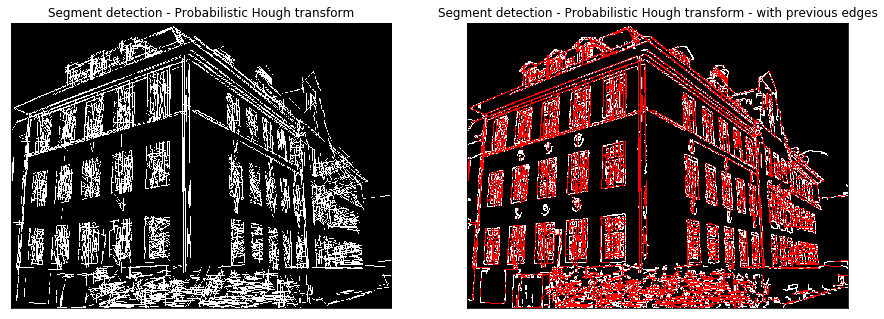

In [6]:
img_edges, lines_p, img_edges_segment, img_segment = sd.segHough(building, ed.edgesDetectionFinal, rho=1, theta=np.pi / 180, thresh=20, minLineLen=15,
                                       maxLineGap=4, kSize=2)
multiDisplay(['Segment detection - Probabilistic Hough transform', 
              'Segment detection - Probabilistic Hough transform - with previous edges'], 
             [img_segment, img_edges_segment], 2)

### 1.3.2 Line Segment Detection algorithm

**How to install pylsd binding**
cf. first cell with import.



**LSD algorithm**

LSD is an algorithm initially written by french researchers  (Grompone R. & al) in C++ and openCV alongside a paper published in the IPOL journal ("LSD: a Line Segment Detector", 2012) . It consists in a set of operations designed to work on most of grey images without required parameters tuning. We have used the given Python C++ binding (**pylsd**)

The algorithm consist in several defined steps:

**Image scaling:** At first, LSD proceeds to a 80% scaling of the input image. This results in a 36% reduction in number of pixel. This is useful to reduce noise (relating to gradient threshold for edge candidates) and to avoid aliasing and quantification artifacts, especially the staircase effect. The scale factor was empirically chosen to resolve the staircase effect. The sub-sampling of the image is done by a Gaussian kernel of $\sigma=0.75$, according to the paper, this sigma value is a good trade-off between avoiding aliasing and avoiding image blurring.

**Gradient computation:** The main goal is to state the orientation and the magnitude of colour gradient for each pixel. To do so, the algorithm proceed to a simple 2x2 size kernel operation and define the x and y gradients, orientation and magnitude.

When the magnitudes are known, the less significant ones under a given threshold are dropped because they are considered as slow edge or flat zones. The algorithm then focus directly on the edges.  

**Region Growing:** It starts with the highest gradient pixels and proceeds to an 8-neighbours flooding recursive call. All the pixels in the neighbour having the same orientation than the current proceeding region up to given tolerance (22.5°) are added to the region. At the end, the region will be composed of a group of pixel and will be surrounded by a rectangle to draw the line segments. The region orientation is initialised by the first pixel level-line angle. Then, each time a pixel is added, it updates its orientation with the following formula.

$\text{new region orientation = } arctan(\frac{\sum_{(x,y)\in Neighbour}sin(level-line-angle_{(x,y)})}{\sum_{(x,y)\in Neighbour} cos(level-line-angle_{(x,y)}})$

**Rectangular Approximation:** The determined regions are treated individually as solid object. The centre of mass of a region is computed with the magnitudes of the corresponding pixels. The dimensions of the rectangle are chosen to be the smallest possible dimensions containing all the region pixel. We can make an analogy with the "Mecanique des matériaux" course, the orientation of the rectangle is chosen to make it having the smallest inertia to rotation possible (according to the main axis, orientation).

**Complexity:** The overall algorithm has a linear complexity because each step describes above visit all pixels to proceed to a constant complexity operation or has a complexity bounded by the number of pixel in the image.

**Internal parameters:** There are several internal parameters in LSD, the one from the previous explanation are the following: S,$\Sigma$,$\rho$ and $\pi$. S is the scaling factor which is set at 80%. $\Sigma$ is the parameters which will defined the Gaussian subsampling. $\sigma = \frac{\Sigma}{S}$, because of that $\Sigma = 0.6$. $\pi$ is the degree tolerence used in the region growing process. $\rho$ is the gradient threshold under which pixels are dropped for processing, it's recommanded value is around 6.

**Limitations:** One of the possible limitations which is due to its 2x2 kernel gradient size is the presence of slow edges, it tends to correct it with the down sampling but some scenarios could still give problem. Light shadow on a white wall for instance.
Their is also a limitation coming from the curves. After rectangular approximation, the algoritm proceeds to a validation based on aligned points. If the image is composed of curves similar in their curvature and no lines, then the algorithm will match the curves with very small tangent line segments. Another limitation is related to the images representation. The algorithm works with image opened in grey scale mode. When the image is converted into grey scale, we can lose information about color edges and we will never detect them with gradient computation. It is the case between pure green and pure red for instance.

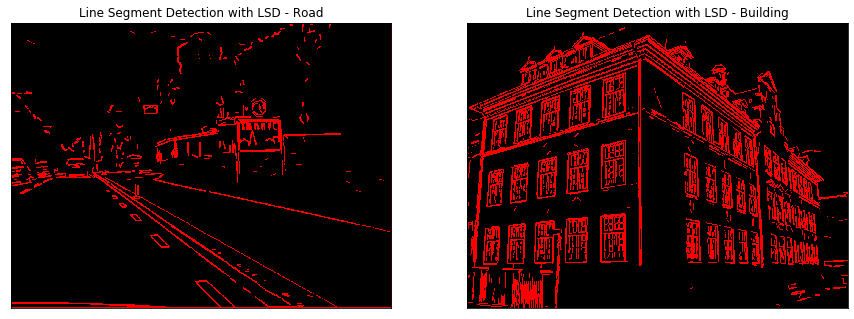

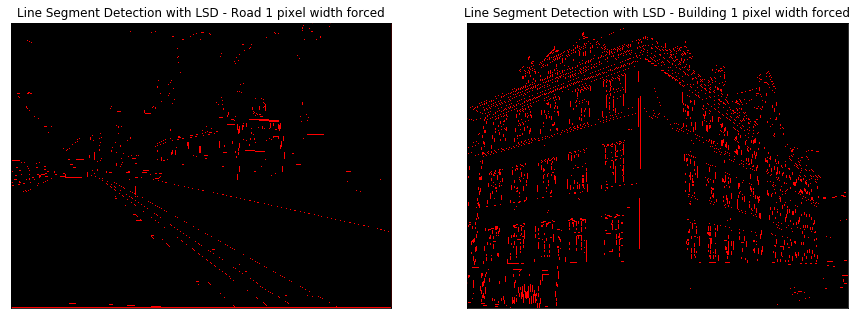

In [7]:
# import lsd algorithm
from LSD import lsd_alg

multiDisplay(['Line Segment Detection with LSD - Road', 
              'Line Segment Detection with LSD - Building'], 
             [lsd_alg(road)[1], lsd_alg(building)[1]], 2)

multiDisplay(['Line Segment Detection with LSD - Road 1 pixel width forced', 
              'Line Segment Detection with LSD - Building 1 pixel width forced'], 
             [lsd_alg(road, line_width=1)[1], lsd_alg(building, line_width=1)[1]], 2)

### 1.3.3 Fusing adjacent segments

The segment detection used previously is not prefect. One of the imprefection lays in the fact of mutliple segments drawn close to each other to describe the same unique edge. In order to solve this problem, 'close segments' will be fused together.

The segments detected are given in the cartesian space with their two endpoints which makes it difficult to characterize the proximity of two edges. In contrast, the Hough space can easily describe the distance between two segments and fuse them if needed. Thus, the idea of the algorithm is to map the segments in a variant of the Hough space, fuse all close segments then map the segments back to the cartesian space.

#### Mapping from cartesian to a variant of the Hough space

Let's take the example of one segment described by the two points: $A = (a_v, a_h)$ and $B = (b_v, b_h)$ where $(i,j)$ is the point with $i$ in vertical value and $j$ in horizontal values and the origin is fixed at the top left corner of the image.

The Hough space will be described by 4 values : $\theta, \rho, p, d$

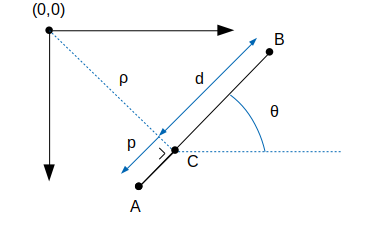

By convention, $A$ will be such that $a_h < b_h$.

$$\left\{
    \begin{array}{ll}
      \theta = \pi - arctan \Big(\frac{|b_v - a_v|}{|b_h-a_h|} \Big) & \text{if $a_v < b_v$}\\
      \theta = arctan \Big(\frac{|b_v - a_v|}{|b_h-a_h|} \Big) & \text {else}
    \end{array}
  \right.$$

$$$$

$\rho$ must be lower than zero  when $c_h < 0$. However, $c_h$ has not been computed yet. Thus, the intersection between the line and $x = 0$ will be computed instead. If, this point has a horizontal value lower than 0, it means $c_h < 0$ and thus $\rho < 0$. Thus, 
$$\left\{
    \begin{array}{ll}
      \rho_{final} = - \frac{|| \overrightarrow{AB} \times \overrightarrow{OA} ||}{|| \overrightarrow{AB} ||} & \text{if $a_h - a_v \frac{a_h-b_h}{a_v-b_v} < 0$} \\
      \rho = \frac{|| \overrightarrow{AB} \times \overrightarrow{OA} ||}{|| \overrightarrow{AB} ||} & \text{else}
    \end{array}
  \right.$$
  
$$C = 
\left(
    \begin{array}{ll}
      c_v\\
      c_h
    \end{array}
\right) = 
\left(
    \begin{array}{ll}
      \rho * cos(\theta) \\
      \rho * sin(\theta)
    \end{array}
\right)$$

$$p = \left\{
        \begin{array}{ll}
          -sign(c_h-a_h) * ||\overrightarrow{AC}|| & \text{ if } a_h < b_h \text{ or } (a_h = b_h \text{ & } a_v > b_v) \\
          -sign(c_h-b_h) * ||\overrightarrow{BC}|| & \text{ else }
        \end{array}
      \right.$$
$$d = ||\overrightarrow{AB}||$$


#### Mapping back from the variant of the Hough space to  the cartesian space
This action allows to go back in the cartesian space after fusing the close segments.

$$A = 
\left(
    \begin{array}{ll}
      a_v\\
      a_h
    \end{array}
\right) = \left(
        \begin{array}{ll}
          c_v - sign(\frac{\pi}{2}-\theta) * p * sin(\theta)\\
          c_h + sign(\frac{\pi}{2}-\theta) * p * cos(\theta)
        \end{array}
      \right) \qquad
B = 
\left(
    \begin{array}{ll}
      b_v\\
      b_h
    \end{array}
\right) = \left(
        \begin{array}{ll}
          c_v - sign(\frac{\pi}{2}-\theta) * (p+d) * sin(\theta) \\
          c_h + sign(\frac{\pi}{2}-\theta) * (p+d) * cos(\theta)
        \end{array}
      \right)$$

#### Fusing two segments
Two segments will be fused together if they fulfill the conditions below. The two first conditions are restricting the orientation and position of the lines extending the segments while the last one restrict the position of the segment on the line. Then to fuse two segments, the two segments are removed and a new one is created.

$$\left\{
        \begin{array}{ll}
          \Big| \theta_1-\theta_2\Big| \leq \Delta_{\theta}\\
          \Big| \rho_1-\rho_2\Big| \leq \Delta_{\rho}\\
          \Big( p_1 \leq p_2 \quad \text{ & } \quad p_1+d_1 > p_2 \Big) \text{ or }
				    \Big( p_2 \leq p_1  \quad \text{ & } \quad  p_2+d_2 > p_1 \Big)
        \end{array}
      \right.
      \qquad
      \left\{
        \begin{array}{ll}
          \theta_n = \frac{\theta_1+\theta_2}{2}\\
          \rho_n = \frac{\rho_1+\rho_2}{2}\\
          p_n = min(p_1, p_2)\\
          d_n = max(p_1+d_1, p_2+d_2) - p_n
        \end{array}
      \right.$$



In [ ]:
img_edges, lines_p, img_edges_segment, img_segment = sd.segHough(building_gray, ed.edgesDetectionFinal, rho=1, theta=np.pi / 180, thresh=20, 
                                      minLineLen=15, maxLineGap=4, kSize=2)

def update(dRho=1, dTheta=1/360*np.pi*2):
    img_edges2, lines_p2, img_edges_segment2, img_segment2 = sd.segHough(building_gray, ed.edgesDetectionFinal, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=dTheta,
                                             dRho = dRho)
    multiDisplay([f"Segments with previously detected edges - {len(lines_p)} segments", 
                  f"Segments with previously detected edges - {len(lines_p2)} segments - segments fused",
                  f"Segments - {len(lines_p)} segments",
                  f"Segments - {len(lines_p2)} segments - segments fused"],
                 [img_edges_segment, img_edges_segment2, img_segment, img_segment2], 2, height=10)
    #display(f"Segments - {len(lines_p2)} segments - segments fused",
    #         img_edges_segment2)

interact(update, dRho = (0,10,1), dTheta = (1/360*np.pi*2, 20/360*np.pi*2, 1/360*np.pi*2))

## 1.4. Segments and endpoints classification

The technique used consists in a simple matrix manipulation.
Considering $E$ a matrix of size $m*n$, the image containing the edges
and $S$ a matrix of the same size, the image containing the segments
. We obtain $ES$ the matrix with all edges belonging to a segment and
$ENS$ the matrix with all the other edges by this calculation :

$ES = E.*S$ and $ENS = E .- ES$ (unitary multiplication and subtraction)

The results are very satisfying.

In [ ]:
img_edges_segment, img_edges, img_line_edges, img_not_line_edges = ec.edge_classifier(road_gray)
multiDisplay(['Segment classification - edges and segments', 'Segment classification - pixels being edge',
              'Segment classification - pixels being segment and edge', 
              'Segment classification - pixels being edge but not segment'],
             [img_edges_segment, img_edges, img_line_edges, img_not_line_edges], 2, height=10)


## 1.5. Evaluation on databases

In [ ]:
# Getting the images
sudoku, sudokuBgr, soccer, road, pcb, building, buildingBgr = im.import_images()

### 1.5.1. Sudoku

For the sudoku dataset, the LSD algorithm already worked fine. The only problem was that thick lines of the image were detected as two lines (one for each border). To remove this problem, we use the fuse segment algorithm described earlier. This has the advantage of having less segments. However, fusing the segment also means losing a bit of information as the fused segment will be an average of the segments. However, this is negligeable in this dataset.

As end result, the grid is almost perfectly shown and even some numbers are well detected. This is a very satisfaying result.

In [ ]:
dispNames = []
dispImgs = []

for i in range(3):
    img_edges2, lines2, img_edges_segment2, img_segment2 = sd.segmentDetectorFinal(sudokuBgr[i], dataset='sudoku', lineWidth=2)
    dispNames.append(f"{sudokuNames[i]} - {len(lines2)} segments")
    dispImgs.append(img_segment2)
multiDisplay(dispNames, dispImgs, 3, width=30, height=15)

### 1.5.2. Soccer

The main idea used for the soccer dataset was to notice that all the interesting data is on the field that has a green background. Since we want the white lines, a region of the HSV domain is extracted corresponding to green hues, low saturations and high values. This image is then converted back to BGR and given to the LSD algorithm. HSV extraction makes it easy to exclude the public and some players.

Additional treatment could be provided to merge the segments together and keep only those that really represent a line of the field.

In [ ]:
dispNames = []
dispImgs = []
for i in range(3):    
    img_edges2, lines2, img_edges_segment2, img_segment2 = sd.segmentDetectorFinal(soccer[i], dataset="soccer")
    dispNames.append(f"{soccerNames[i]} - {len(lines2)} segments")
    dispImgs.append(img_segment2)
multiDisplay(dispNames, dispImgs, 3, width=30, height=15)

### 1.5.3. Road

For this dataset, it was tried to extract only the area of the road but it did not succeed. The idea was to fit 3 gaussians on the histogram of the grayscale image. A hypothesis was then made: the gaussian on the white side represented the sky, the grey side the road and the black side the shaded areas and the shoulders of the road. Some results were not bad, but a flood algorithm was used to determine the road contour and it was very detailed. One would have liked to simplify it as a polygon but did not succeed. The results available in the images below are therefore a simple use of the LSD algorithm.

In [ ]:
dispNames = []
dispImgs = []
for i in [0, 11, 22]:    
    img_edges2, lines2, img_edges_segment2, img_segment2 = sd.segmentDetectorFinal(roadBgr[i], dataset="road")
    dispNames.append(f"{roadNames[i]} - {len(lines2)} segments")
    dispImgs.append(img_segment2)
multiDisplay(dispNames, dispImgs, 3, width=30, height=15)

### 1.5.4. Pcb

For PCBs, the main goal was to extract as many components as possible, the main difficulties being that the printed circuit, dust or other perturbations such as the angle at which the photograph was taken made the task of detecting those components more difficult. The approach taken was to first blur the image using a Gaussian blur and to downscale and upscale the size of the image to remove some small imperfections such as dust. To sharpen the edges, OpenCv's erode function was used (it computes a local minimum over the kernel area). Finally, Canny and the probabilitic Hough transform were used to detect the lines. 

In [ ]:
dispNames = []
dispImgs = []

for i in range(3):
    img_edges2, lines2, img_edges_segment2, img_segment2 = sd.segmentDetectorFinal(pcb[i], dataset='pcb', lineWidth=2)
    dispNames.append(f"{pcbNames[i]} - {len(lines2)} segments")
    dispImgs.append(img_segment2)
multiDisplay(dispNames, dispImgs, 3, width=30, height=15)

### 1.5.5. Building
The LSD algorithm send back results which are good enough to recognise building and windows borders. To get the main orientation of the building, we tried a hierarchical clustering with scikit-learn. The objectif was to agglomerate lines with similar orientation. To do so, we fixed the number of clustering to 4 with a cosine similarity measure and an average linkage. The input vector is the $\Delta x$ and the $\Delta y$ of each line segments by LSD. The deltas were modified to have their orientation (direction) in the 1st and 4th quadrants. We used 4 clusters because their is a discountinuity between 90° and - 90°, this results most of the time in two big clusters around these values. We also try to balance the weight of each input by putting some of them several time. According to the ratio between their euclidean distance and the euclidean distance of the image diagonal. 

When we observe the result, we have most of the time 2 clusters for each main axis (width and height axis). Because the "labels" (x,y and z axis + noise label) represent an unbalanced classification problem. Even if some lines represent the building depth, the algorithm will prefer to create a second cluster for the width axis. It is even more unbalanced with noise (road, roof, wall straight line pattern, unaligned neighbour building, etc). Another problem encounter is related to the angle of the picture. When the picture was taken in front of the building, it is then easier. But when it is taken from the side, the horizontal lines from the building front converge and then their orientation value diverge from each other. 

To improve it, we need a method which allow computing distances in a "circular" range, to avoid discontinuity. Or determined a custom distance matrix. In order to recompute the missing orientation, it can be possible to make a guess with an heuristic method using only the two first orientation.

In [ ]:
from LSD import lsd_alg
from LSD import lsd_getAxis

dispNames = []
dispImgs = []
for i in range(3):    
    print(f"Orientation (in degrees) and cluster size for picture {roadNames[i]}")
    tmp1, tmp2 = lsd_getAxis(buildingBgr[i])
    print(tmp1)
    print(tmp2)
    print()
    img_edges2, lines2, img_edges_segment2, img_segment2 = sd.segmentDetectorFinal(buildingBgr[i], dataset="road")
    dispNames.append(f"{roadNames[i]} - {len(lines2)} segments")
    dispImgs.append(img_segment2)
multiDisplay(dispNames, dispImgs, 3, width=30, height=15)